In [115]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import sqlite3
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,classification_report,f1_score
from sklearn.decomposition import TruncatedSVD
from sklearn import cross_validation
from sklearn.cross_validation import cross_val_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import gensim
from sklearn.model_selection import train_test_split

In [2]:
# creating sql connection string
con = sqlite3.connect('database.sqlite')

In [3]:
filtered_data = pd.read_sql_query('SELECT * from Reviews WHERE Score != 3',con)

In [4]:
actual_scores = filtered_data['Score']
positiveNegative = actual_scores.map(lambda x: 'Positive' if x>3 else 'Negative')
filtered_data['Score'] = positiveNegative

In [5]:
final = filtered_data.drop_duplicates(subset= { 'UserId', 'ProfileName', 'Time',  'Text'})

In [6]:
print('Rows dropped : ',filtered_data.size - final.size)
print('Percentage Data remaining after dropping duplicates :',(((final.size * 1.0)/(filtered_data.size * 1.0) * 100.0)))

Rows dropped :  1616410
Percentage Data remaining after dropping duplicates : 69.25890143662969


In [7]:
# Dropping rows where HelpfulnessNumerator < HelpfulnessDenominator
final = final[final.HelpfulnessDenominator >= final.HelpfulnessNumerator]

In [8]:
print('Number of Rows remaining in the Dataset: ',final.size)

Number of Rows remaining in the Dataset:  3641710


In [9]:
# Data Sampling
final = final.iloc[:50000,:]


# Checking the number of positive and negative reviews

Class_Count  = final['Score'].value_counts()
print(final['Score'].value_counts())

Positive    41815
Negative     8185
Name: Score, dtype: int64


In [10]:
# Sorting values according to Time for Time Based Slicing
final = final.sort_values('Time',kind = 'quicksort')

# Text Preprocessing: Stemming, stop-word removal and Lemmatization.
Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

Begin by removing the html tags
Remove any punctuations or limited set of special characters like , or . or # etc.
Check if the word is made up of english letters and is not alpha-numeric
Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
Convert the word to lowercase
Remove Stopwords
Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)
After which we collect the words used to describe positive and negative reviews

In [31]:
# Function to Remove HTML Tags
def cleanhtml(sentence):
    cleaner = re.compile('<.*?>')
    cleantext = re.sub(cleaner,"",sentence)
    return cleantext

In [32]:
# Function to clean punctuations and special characters

def cleanpunct(sentence):
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [34]:
# Initialize Stop words and PorterStemmer and Lemmetizer
stop = set(stopwords.words('english'))
sno = SnowballStemmer('english')





In [35]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1

In [36]:
final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
1146,1245,B00002Z754,A29Z5PI9BW2PU3,Robbie,7,7,Positive,961718400,Great Product,This was a really good idea and the final prod...,b'realli good idea final product outstand use ...
1145,1244,B00002Z754,A3B8RCEI0FXFI6,B G Chase,10,10,Positive,962236800,WOW Make your own 'slickers' !,I just received my shipment and could hardly w...,b'receiv shipment could hard wait tri product ...
28087,30630,B00008RCMI,A284C7M23F0APC,A. Mendoza,0,0,Positive,1067040000,Best sugarless gum ever!,I love this stuff. It is sugar-free so it does...,b'love stuff doesnt rot gum tast good go buy g...
28086,30629,B00008RCMI,A19E94CF5O1LY7,Andrew Arnold,0,0,Positive,1067040000,"I've chewed this gum many times, but used?","Nothing against the product, but it does bothe...",b'noth product bother link top page buy use ch...
38740,42069,B0000EIEQU,A1YMJX4YWCE6P4,"Jim Carson ""http://www.jimcarson.com""",12,12,Positive,1067558400,These limes rule!,"Fresh limes are underappreciated, but a joy to...",b'fresh lime underappreci joy kitchen squirt l...


In [37]:
#Dictionary for storing Metrics
Final_Metrics =pd.DataFrame()

In [139]:
def runNB(X_train, X_test, y_train, y_test, Vectorization):
   # print(X_train.shape, y_train.shape)
    global Final_Metrics
    cv_scores = []
    k_value = []
    
    Train_Scores = []
    Test_Scores = []
    
    algo = 'NaiveBayes'
    j = 0
    
    for i in range(2,30,2):
        
        nb = BernoulliNB(alpha=i)
       
        
        scores = cross_val_score(nb, X_train, y_train, cv = 10, scoring = 'accuracy')
        
        cv_scores.append(scores.mean())
        k_value.append(i)
        
        print('For alpha = ', i,'Accuracy Score = ', cv_scores[j])
        
        j+= 1
        
    alpha_optimum = k_value[cv_scores.index(max(cv_scores))]
    plt.plot(k_value,cv_scores,'-o')
    plt.xlabel('Alpha Value')
    plt.ylabel('CV-Scores')
    plt.title('Alpha Value vs CV-Scores')       
    nb = BernoulliNB(alpha=alpha_optimum)
   # print(X_train.shape, y_train.shape)
        # fitting the model on crossvalidation train
    nb.fit(X_train, y_train)

        # predict the response on the crossvalidation train
    pred = nb.predict(X_test)

        # evaluate CV accuracy
        #acc = accuracy_score(y_cv_input, pred, normalize=True) * float(100)
    print('\nDetails for ',Vectorization,'Vectorization:')
    print('*'*100)
    print('Accuracy for',algo,' algorithm with alpha =',alpha_optimum,' is ' ,np.round((accuracy_score(y_test, pred)*100),decimals = 2))
    print('F1 score for',algo,' algorithm with alpha =',alpha_optimum,' is ' , np.round((f1_score(y_test, pred,average= 'macro')*100),decimals = 2))
    print('Recall for',algo,' agorithm with alpha =',alpha_optimum,' is ' , np.round((recall_score(y_test, pred,average= 'macro')*100),decimals = 2))
    print('Precision for',algo,' algorithm with aplha =',alpha_optimum,' is ' , np.round((precision_score(y_test, pred,average= 'macro')*100),decimals = 2))
    print ('\n Classification report for',algo,' algorithm with alpha =',alpha_optimum,' is \n ' , classification_report(y_test,pred))    
    Train_Scores.append(nb.score(X_train, y_train))
    Test_Scores.append(nb.score(X_test, y_test))
      
    Temp_List = [algo,Vectorization,alpha_optimum,nb.score(X_train, y_train)*100,nb.score(X_test, y_test)*100]
        #print(Temp_List)
    Final_Metrics = Final_Metrics.append({'Algorithm': algo,'Vectorization':Vectorization,'HyperParameter':alpha_optimum,
                                              'Training Accuracy Score': nb.score(X_train, y_train)*100,
                                              'Testing Accuracy Score':nb.score(X_test, y_test)*100},
                                            ignore_index=True)
    
    
    plt.figure()
    confusion_matrix_Plot = confusion_matrix(y_test,pred)
    heatmap = sns.heatmap(confusion_matrix_Plot, annot=True, fmt="d")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    

# BOW

In [124]:
#Splitting into Training and Testing Set
X_train,X_test,y_train,y_test = train_test_split(final['CleanedText'],final['Score'])

(37500, 26017) (37500,)
For alpha =  2 Accuracy Score =  0.8476535755946839
For alpha =  4 Accuracy Score =  0.8381869583208503
For alpha =  6 Accuracy Score =  0.8339469866477265
For alpha =  8 Accuracy Score =  0.8321067732536964
For alpha =  10 Accuracy Score =  0.8325600923951473
For alpha =  12 Accuracy Score =  0.8332266239791377
For alpha =  14 Accuracy Score =  0.8335199146609715
For alpha =  16 Accuracy Score =  0.833999964463405
For alpha =  18 Accuracy Score =  0.8343466311490344
For alpha =  20 Accuracy Score =  0.8348533547311423
For alpha =  22 Accuracy Score =  0.8349599716295091
For alpha =  24 Accuracy Score =  0.8351732836389889
For alpha =  26 Accuracy Score =  0.8353066240853302
For alpha =  28 Accuracy Score =  0.8353866311945456
(37500, 26139) (37500,)

Details for  Bag of Words Vectorization:
****************************************************************************************************
Accuracy for NaiveBayes  algorithm with alpha = 2  is  85.27
F1 score fo

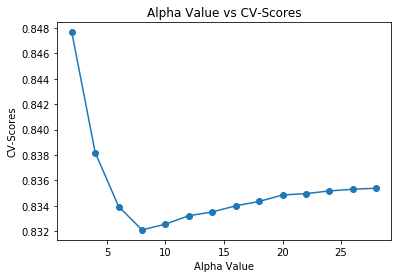

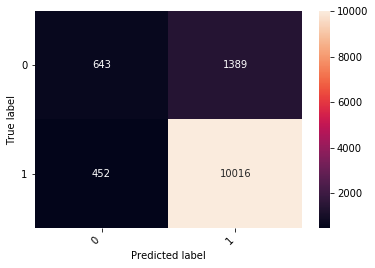

In [125]:
# BoW Vectorization

vect = CountVectorizer().fit(X_train)
X_train = vect.transform(X_train)
X_test = vect.transform(X_test)
#print(X_Train)
runNB(X_train,X_test,y_train,y_test,'Bag of Words')

# Tfidf

In [129]:
tf_idf_vec = TfidfVectorizer()#ngram_range=(2,2))

final_tfidf_count = tf_idf_vec.fit_transform(final_string)#final['Text'].values)

In [130]:
from sklearn.preprocessing import StandardScaler

final_tfidf_np = StandardScaler(with_mean=False).fit_transform(final_tfidf_count )

(35000, 30287) (35000,)
For alpha =  2 Accuracy Score =  0.847028575267639
For alpha =  4 Accuracy Score =  0.8416288278880677
For alpha =  6 Accuracy Score =  0.8394570889352725
For alpha =  8 Accuracy Score =  0.8404285012594694
For alpha =  10 Accuracy Score =  0.8406857012804654
For alpha =  12 Accuracy Score =  0.8416285993166204
For alpha =  14 Accuracy Score =  0.8421714809935903
For alpha =  16 Accuracy Score =  0.8423143299848432
For alpha =  18 Accuracy Score =  0.8423428769259491
For alpha =  20 Accuracy Score =  0.8428856932967912
For alpha =  22 Accuracy Score =  0.843057138208746
For alpha =  24 Accuracy Score =  0.8432857423090401
For alpha =  26 Accuracy Score =  0.8432857423090401
For alpha =  28 Accuracy Score =  0.8432571953679343
(35000, 30287) (35000,)

Details for  TF-IDF Vectorization:
****************************************************************************************************
Accuracy for NaiveBayes  algorithm with alpha = 2  is  83.96
F1 score for Naive

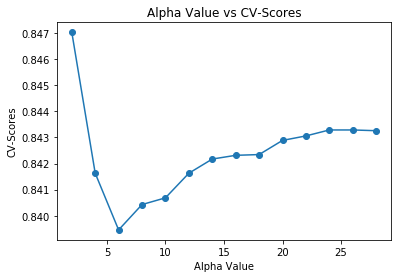

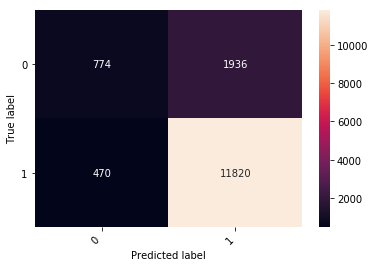

In [131]:
X = final_tfidf_np
y = final['Score']

X_train =  final_tfidf_np[:math.ceil(len(final)*.7)] 
X_test = final_tfidf_np[math.ceil(len(final)*.7):]
y_train = y[:math.ceil(len(final)*.7)]
y_test =  y[math.ceil(len(final)*.7):]
runNB(X_train,X_test,y_train,y_test,'TF-IDF')

# W2V

In [132]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

In [133]:
import gensim
i=0
str1=''
list_of_sent=[]
final_string_for_tfidf = []
for sent in final['Text'].values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    str1 = ''
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (cleaned_words.lower() not in stop)):    
                filtered_sentence.append(cleaned_words.lower())
                str1 += " "+cleaned_words.lower() 
            else:
                continue
    #str1 = b" ".join(filtered_sentence) #final string of cleaned words
            
    #final_string_for_tfidf.append(str1)
    list_of_sent.append(filtered_sentence)
    final_string_for_tfidf.append((str1).strip())

In [134]:
w2v_model=gensim.models.Word2Vec(list_of_sent,min_count=5,size=50, workers=4)  

In [135]:
sent_vectors = []; 
for sent in list_of_sent: 
    sent_vec = np.zeros(50)
    cnt_words =0; 
    for word in sent: 
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)

For alpha =  2 Accuracy Score =  0.8493429672933036
For alpha =  4 Accuracy Score =  0.8493144040256656
For alpha =  6 Accuracy Score =  0.849257261163858
For alpha =  8 Accuracy Score =  0.8494286081166212
For alpha =  10 Accuracy Score =  0.8493714326017496
For alpha =  12 Accuracy Score =  0.8494571713842589
For alpha =  14 Accuracy Score =  0.8492571305516025
For alpha =  16 Accuracy Score =  0.8493999632163236
For alpha =  18 Accuracy Score =  0.8493142407603461
For alpha =  20 Accuracy Score =  0.8493999958693873
For alpha =  22 Accuracy Score =  0.8494570897515992
For alpha =  24 Accuracy Score =  0.8496856285457657
For alpha =  26 Accuracy Score =  0.84988565305189
For alpha =  28 Accuracy Score =  0.8499142489725917

Details for  W2V Vectorization:
****************************************************************************************************
Accuracy for NaiveBayes  algorithm with alpha = 28  is  83.75
F1 score for NaiveBayes  algorithm with alpha = 28  is  70.97
Recall 

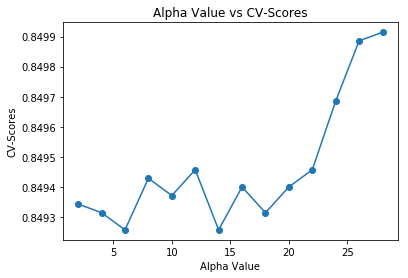

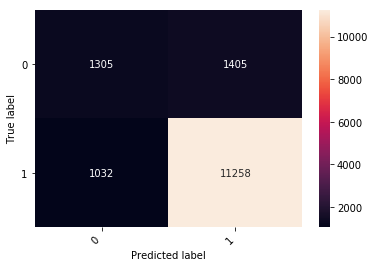

In [140]:
import math
from sklearn import datasets
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split

X = sent_vectors #final_w2v_count
y = final['Score']

X_train =  sent_vectors[:math.ceil(len(final)*.7)]  #final_w2v_count
X_test = sent_vectors[math.ceil(len(final)*.7):] #final_w2v_count
y_train = y[:math.ceil(len(final)*.7)]
y_test =  y[math.ceil(len(final)*.7):]

runNB(X_train,X_test,y_train,y_test,'W2V')

# tfidf Avg. W2V

In [141]:
tf_idf_vec_w = TfidfVectorizer()#ngram_range=(2,2))

final_tfidf_w = tf_idf_vec_w.fit_transform(final_string_for_tfidf)

In [142]:
tfidf_feat = tf_idf_vec_w.get_feature_names()


tfidf_sent_vectors = [];
row=0;
for sent in list_of_sent:  
    sent_vec = np.zeros(50) 
    weight_sum =0;
    for word in sent:
        try:
            vec = w2v_model.wv[word]
            tf_idf = final_tfidf_w[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except Exception as e: 
            pass #print(e)
            
    try:
        sent_vec /= weight_sum
    except:
        print(e)
        
    tfidf_sent_vectors.append(sent_vec)
    row += 1

For alpha =  2 Accuracy Score =  0.8486566815229946
For alpha =  4 Accuracy Score =  0.8486852611171642
For alpha =  6 Accuracy Score =  0.8487995631673112
For alpha =  8 Accuracy Score =  0.8488281264349491
For alpha =  10 Accuracy Score =  0.8487709835731414
For alpha =  12 Accuracy Score =  0.8489995550203717
For alpha =  14 Accuracy Score =  0.8489138488909264
For alpha =  16 Accuracy Score =  0.8486566978495264
For alpha =  18 Accuracy Score =  0.8485995713142508
For alpha =  20 Accuracy Score =  0.8485710243731448
For alpha =  22 Accuracy Score =  0.8484853345702312
For alpha =  24 Accuracy Score =  0.8485425264116347
For alpha =  26 Accuracy Score =  0.84865681213525
For alpha =  28 Accuracy Score =  0.8486853590763559

Details for  Avg.weighted W2V Vectorization:
****************************************************************************************************
Accuracy for NaiveBayes  algorithm with alpha = 12  is  83.69
F1 score for NaiveBayes  algorithm with alpha = 12  is 

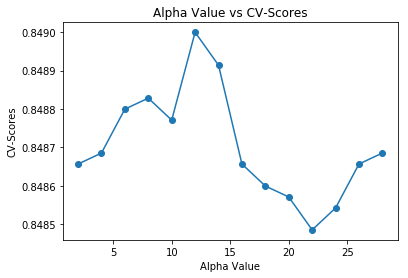

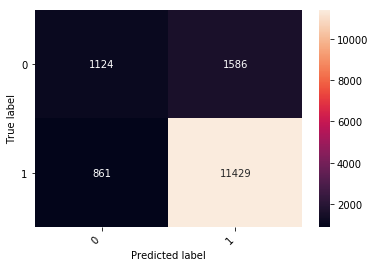

In [143]:
X = tfidf_sent_vectors
y = final['Score']

X_train =  tfidf_sent_vectors[:math.ceil(len(final)*.7)] 
X_test = tfidf_sent_vectors[math.ceil(len(final)*.7):]
y_train = y[:math.ceil(len(final)*.7)]
y_test =  y[math.ceil(len(final)*.7):]

runNB(X_train,X_test,y_train,y_test,'Avg.weighted W2V')